<a href="https://colab.research.google.com/github/franchesco98/Red-convolucional-plantas/blob/main/red_convolucional_plantas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descarga del conjunto completo de entrenamiento.

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1A40ASJvKWE5QMnqhpxhkWF4gCd9EZoXm # Conjunto de entrenamiento entero de imágenes

Downloading...
From: https://drive.google.com/uc?id=1A40ASJvKWE5QMnqhpxhkWF4gCd9EZoXm
To: /content/Tarea1.zip
493MB [00:02, 230MB/s]


Exportar el zip con el conjunto de entrenamiento.

In [ ]:
import zipfile

carpeta_zip_imagenes = '/content/Tarea1.zip'

archivo_zip = zipfile.ZipFile(carpeta_zip_imagenes, 'r')
 
archivo_zip.extractall('/content/Tarea1')
archivo_zip.close()

Guardar el directorio de las carpetas con las imágenes de entrenamiento, validación y prueba en varibales para usarlas luego en los generadores.

In [ ]:
import os
carpeta_base_imagenes = '/content/Tarea1'
 
conjunto_entrenamiento = os.path.join(carpeta_base_imagenes, 'train')
conjunto_validacion = os.path.join(carpeta_base_imagenes, 'val')
conjunto_prueba = os.path.join(carpeta_base_imagenes, 'test')

Creación del modelo de red convolucional.

In [ ]:
!pip install tensorflow-addons~=0.7 # Instalación del addon de tensorflow, para poder usar group normalization ()
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
model = Sequential([
  Conv2D(64, (11,11), input_shape = (256, 256, 3), kernel_initializer = 'he_uniform'),
  tfa.layers.GroupNormalization(groups = 4, axis = 3), 
  Activation('relu'),
  MaxPooling2D(2,2),
  Dropout(0.2),

  Conv2D(64, (11,11), kernel_initializer = 'he_uniform'),
  tfa.layers.GroupNormalization(groups = 4, axis = 3), 
  Activation('relu'),
  MaxPooling2D(2,2),
 
  Conv2D(128, (11,11), kernel_initializer = 'he_uniform'),
  tfa.layers.GroupNormalization(groups = 4, axis = 3), 
  Activation('relu'),
  MaxPooling2D(2,2),

  Conv2D(256, (11,11), kernel_initializer = 'he_uniform'),
  tfa.layers.GroupNormalization(groups = 4, axis = 3), 
  Activation('relu'),
  MaxPooling2D(2,2),
  Dropout(0.2),
 
  Flatten(),

  Dense(9, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 246, 246, 64)      23296     
_________________________________________________________________
group_normalization (GroupNo (None, 246, 246, 64)      128       
_________________________________________________________________
activation (Activation)      (None, 246, 246, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 123, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 113, 113, 64)      495680    
_________________________________________________________________
group_normalization_1 (Group (None, 113, 113, 64)      1

Ejecución del entrenamiento de la red neuronal.

In [ ]:
# Normalización de las imágenes de prueba, así como aplicar data augmentation al conjunto de entrenamiento (haciendo un volteo horizontal a las imágenes).
entrenamiento_generador_datos = ImageDataGenerator(rescale = 1.0/255., horizontal_flip=True)
validacion_generador_datos  = ImageDataGenerator(rescale = 1.0/255.)
prueba_generador_datos  = ImageDataGenerator(rescale = 1.0/255.)

# Tamaño del batch a utilizar en esta red.
batch_size = 32
 
generador_entrenamiento = entrenamiento_generador_datos.flow_from_directory(conjunto_entrenamiento, 
                                                                            batch_size = batch_size, 
                                                                            class_mode = 'categorical', 
                                                                            target_size =(256, 256))     
 
generador_validacion =  validacion_generador_datos.flow_from_directory(conjunto_validacion,
                                                         batch_size = batch_size,
                                                         class_mode = 'categorical',
                                                         target_size = (256, 256))
  
generador_prueba = prueba_generador_datos.flow_from_directory(conjunto_prueba,
                                                         batch_size = batch_size,
                                                         class_mode = 'categorical',
                                                         target_size = (256, 256))

'''
Configuración de la red neuronal, usándose el optimizador RMSprop con un learning rate de 0.0001, 
categorical crossentropy como función de loss, y 'acc' (precisión) como métrica para monitorizar la red
'''
model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

# Con model.fit entrenamos la red.
history = model.fit(
      generador_entrenamiento,
      steps_per_epoch = generador_entrenamiento.n // batch_size,  
      epochs = 30,
      validation_data = generador_validacion,
      validation_steps = generador_validacion.n // batch_size,  
      verbose = 2)

# Calculamos la precisión de la red, así como la loss de esta
loss_prueba, precision_prueba = model.evaluate_generator(generador_prueba)
print ('Loss en el conjunto de prueba:', loss_prueba)
print ('Precisión en el conjunto de prueba:', precision_prueba*100, '%')

Found 12002 images belonging to 9 classes.
Found 3005 images belonging to 9 classes.
Found 2501 images belonging to 9 classes.
Epoch 1/30
375/375 - 75s - loss: 1.6660 - acc: 0.4987 - val_loss: 1.4476 - val_acc: 0.5360
Epoch 2/30
375/375 - 74s - loss: 1.4229 - acc: 0.5267 - val_loss: 1.2949 - val_acc: 0.5464
Epoch 3/30
375/375 - 74s - loss: 1.3166 - acc: 0.5450 - val_loss: 1.2908 - val_acc: 0.5410
Epoch 4/30
375/375 - 74s - loss: 1.2489 - acc: 0.5658 - val_loss: 1.2168 - val_acc: 0.5726
Epoch 5/30
375/375 - 74s - loss: 1.2014 - acc: 0.5778 - val_loss: 1.3633 - val_acc: 0.4956
Epoch 6/30
375/375 - 74s - loss: 1.1475 - acc: 0.5964 - val_loss: 1.0958 - val_acc: 0.6042
Epoch 7/30
375/375 - 74s - loss: 1.0930 - acc: 0.6121 - val_loss: 1.0258 - val_acc: 0.6341
Epoch 8/30
375/375 - 74s - loss: 1.0521 - acc: 0.6251 - val_loss: 1.1372 - val_acc: 0.6092
Epoch 9/30
375/375 - 74s - loss: 1.0274 - acc: 0.6323 - val_loss: 0.9564 - val_acc: 0.6556
Epoch 10/30
375/375 - 74s - loss: 0.9918 - acc: 0.6471

Guardar los pesos calculados en el entrenamiento.

In [ ]:
model.save('/content/modelo-entrega.h5')

Gráficas donde se muestran tanto la precisión en el conjunto de entrenamiento y en el conjunto de validación (primera gráfica), como la loss en el conjunto de entrenamiento y en el conjunto de validación (segunda gráfica).  
**NOTA:** El código para mostrar dichas gráficas está sacado del libro [Deep Learning, Introducción práctica con Keras (SEGUNDA PARTE)](https://torres.ai/datos-y-overfitting-keras-tensorflow/#Visualizacion_del_comportamiento_del_entrenamiento)

<Figure size 432x288 with 0 Axes>

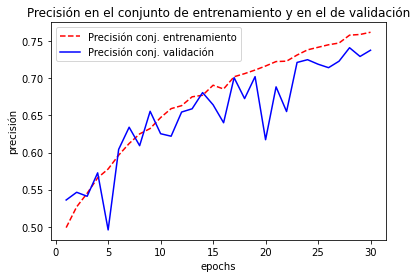

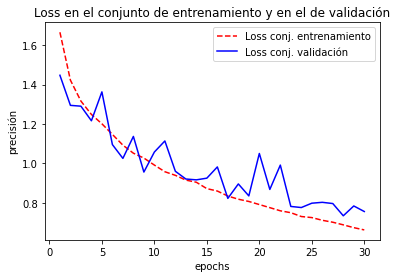

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc      = history.history[     'acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Precisión conj. entrenamiento'  )
plt.plot ( epochs, val_acc,  'b', label='Precisión conj. validación')
plt.title ('Precisión en el conjunto de entrenamiento y en el de validación')
plt.ylabel('precisión')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--', label='Loss conj. entrenamiento')
plt.plot ( epochs, val_loss ,  'b' , label='Loss conj. validación')
plt.title ('Loss en el conjunto de entrenamiento y en el de validación'   )
plt.ylabel('precisión')
plt.xlabel('epochs')

plt.legend()
plt.figure()